In [57]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    self.bn2 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dense = nn.Linear(1600, 10)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool(x)
    x = F.relu(self.bn2(self.conv2(x)))
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.dense(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

summary(CNNModel().cuda(), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 64, 11, 11]          18,496
       BatchNorm2d-5           [-1, 64, 11, 11]             128
         MaxPool2d-6             [-1, 64, 5, 5]               0
            Linear-7                   [-1, 10]          16,010
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.50
Params size (MB): 0.13
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


In [58]:
import torch
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

BATCH_SIZE = 128

(X_train_val, y_train_val), (X_test, y_test) = mnist.load_data()
X_train, X_val, y_train, y_val = \
  train_test_split(X_train_val, y_train_val, test_size=0.2)

X_train = X_train.reshape(-1, 28, 28).astype('float32')
X_val = X_val.reshape(-1, 28, 28).astype('float32')
X_test = X_test.reshape(-1, 28, 28).astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

X_train = torch.from_numpy(X_train).to(torch.float32)
X_val = torch.from_numpy(X_val).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
y_test = torch.from_numpy(y_test).long()

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
validate_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

In [62]:
import torch.optim as optim
import torch.nn as nn

LEARNING_RATE = 1e-3
NUM_EPOCHS = 30

torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(f'Train on {len(train_loader.dataset)} samples, validate on {len(validate_loader.dataset)} samples')

for epoch in range(NUM_EPOCHS):
  train_loss = 0
  val_loss = 0
  train_acc = 0
  val_acc = 0

  model.train()
  for inputs, targets in train_loader:
    inputs = inputs.view(-1, 1, 28, 28).to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_acc += (outputs.max(1)[1] == targets).sum().item()
    train_loss += loss.item()
  avg_train_acc = train_acc / len(train_loader.dataset)
  avg_train_loss = train_loss / len(train_loader)
  train_log = f'acc: {avg_train_acc:.4f} - loss: {avg_train_loss:.4f}'

  model.eval()
  with torch.no_grad():
    for inputs, targets in validate_loader:
      inputs = inputs.view(-1, 1, 28, 28).to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      val_acc += (outputs.max(1)[1] == targets).sum().item()
      val_loss += loss.item()
  avg_val_acc = val_acc / len(validate_loader.dataset)
  avg_val_loss = val_loss / len(validate_loader)
  val_log = f'val_acc: {avg_val_acc:.4f} - val_loss: {avg_val_loss:.4f}'

  print(f'Epoch {epoch+1}/{NUM_EPOCHS} {train_log} - {val_log}')

test_acc = 0
test_loss = 0

model.eval()
with torch.no_grad():
  for inputs, targets in test_loader:
    inputs = inputs.view(-1, 1, 28, 28).to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    test_acc += (outputs.max(1)[1] == targets).sum().item()
  avg_test_acc = test_acc / len(test_loader.dataset)

print(f'Test accuracy: {avg_test_acc}')

Train on 48000 samples, validate on 12000 samples
Epoch 1/30 acc: 0.9532 - loss: 0.1652 - val_acc: 0.9786 - val_loss: 0.0717
Epoch 2/30 acc: 0.9840 - loss: 0.0530 - val_acc: 0.9844 - val_loss: 0.0508
Epoch 3/30 acc: 0.9877 - loss: 0.0408 - val_acc: 0.9828 - val_loss: 0.0533
Epoch 4/30 acc: 0.9902 - loss: 0.0320 - val_acc: 0.9845 - val_loss: 0.0499
Epoch 5/30 acc: 0.9916 - loss: 0.0263 - val_acc: 0.9867 - val_loss: 0.0432
Epoch 6/30 acc: 0.9928 - loss: 0.0222 - val_acc: 0.9838 - val_loss: 0.0529
Epoch 7/30 acc: 0.9940 - loss: 0.0187 - val_acc: 0.9798 - val_loss: 0.0654
Epoch 8/30 acc: 0.9953 - loss: 0.0152 - val_acc: 0.9869 - val_loss: 0.0442
Epoch 9/30 acc: 0.9963 - loss: 0.0121 - val_acc: 0.9876 - val_loss: 0.0415
Epoch 10/30 acc: 0.9967 - loss: 0.0103 - val_acc: 0.9894 - val_loss: 0.0367
Epoch 11/30 acc: 0.9972 - loss: 0.0096 - val_acc: 0.9857 - val_loss: 0.0515
Epoch 12/30 acc: 0.9978 - loss: 0.0076 - val_acc: 0.9893 - val_loss: 0.0394
Epoch 13/30 acc: 0.9983 - loss: 0.0063 - val_ac

In [67]:
!git clone https://github.com/morik20/hand-written-number-recognition.git

Cloning into 'hand-written-number-recognition'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


True digit 1 (0.9998469353), Prediction 1 (0.9998469353)
True digit 1 (0.9999988079), Prediction 1 (0.9999988079)


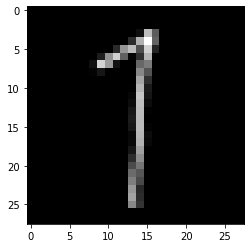

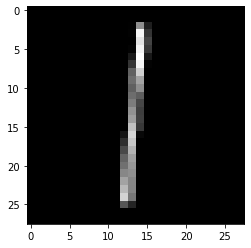

In [91]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_1 = Image.open('/content/hand-written-number-recognition/figs/1_1.png')
img_2 = Image.open('/content/hand-written-number-recognition/figs/1_2.png')
img_1, img_2 = img_1.convert('L'), img_2.convert('L')
img_1, img_2 = img_1.resize((28, 28)), img_2.resize((28, 28))
img_1, img_2 = np.array(img_1), np.array(img_2)

plt.figure()
plt.gray()
plt.imshow(img_1)
plt.figure()
plt.gray()
plt.imshow(img_2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_test = np.array(img_1)
y_test = np.array([1])

X_test = X_test.reshape(-1, 28, 28).astype('float32')
X_test /= 255

X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).long()

model.eval()
with torch.no_grad():
    inputs = X_test.view(1, 1, 28, 28).to(device)
    targets = y_test.to(device)
    # forward
    outputs = model(inputs)

print('True digit {:.0f} ({:.10f}), Prediction {:.0f} ({:.10f})'.format(
    targets.item(),
    torch.softmax(outputs, dim=1)[:, targets].item(),
    outputs.max(1)[1].item(),
    torch.softmax(outputs, dim=1).max(1)[0].item(),
))

X_test = np.array(img_2)
y_test = np.array([1])

X_test = X_test.reshape(-1, 28, 28).astype('float32')
X_test /= 255

X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).long()

model.eval()
with torch.no_grad():
    inputs = X_test.view(1, 1, 28, 28).to(device)
    targets = y_test.to(device)
    # forward
    outputs = model(inputs)

print('True digit {:.0f} ({:.10f}), Prediction {:.0f} ({:.10f})'.format(
    targets.item(),
    torch.softmax(outputs, dim=1)[:, targets].item(),
    outputs.max(1)[1].item(),
    torch.softmax(outputs, dim=1).max(1)[0].item(),
))

True digit 4 (0.8909674287), Prediction 4 (0.8909674287)
True digit 4 (0.9999899864), Prediction 4 (0.9999899864)


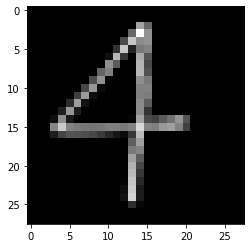

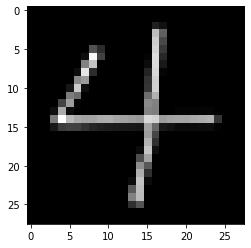

In [93]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_1 = Image.open('/content/hand-written-number-recognition/figs/4_1.png')
img_2 = Image.open('/content/hand-written-number-recognition/figs/4_2.png')
img_1, img_2 = img_1.convert('L'), img_2.convert('L')
img_1, img_2 = img_1.resize((28, 28)), img_2.resize((28, 28))
img_1, img_2 = np.array(img_1), np.array(img_2)

plt.figure()
plt.gray()
plt.imshow(img_1)
plt.figure()
plt.gray()
plt.imshow(img_2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_test = np.array(img_1)
y_test = np.array([4])

X_test = X_test.reshape(-1, 28, 28).astype('float32')
X_test /= 255

X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).long()

model.eval()
with torch.no_grad():
    inputs = X_test.view(1, 1, 28, 28).to(device)
    targets = y_test.to(device)
    # forward
    outputs = model(inputs)

print('True digit {:.0f} ({:.10f}), Prediction {:.0f} ({:.10f})'.format(
    targets.item(),
    torch.softmax(outputs, dim=1)[:, targets].item(),
    outputs.max(1)[1].item(),
    torch.softmax(outputs, dim=1).max(1)[0].item(),
))

X_test = np.array(img_2)
y_test = np.array([4])

X_test = X_test.reshape(-1, 28, 28).astype('float32')
X_test /= 255

X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).long()

model.eval()
with torch.no_grad():
    inputs = X_test.view(1, 1, 28, 28).to(device)
    targets = y_test.to(device)
    # forward
    outputs = model(inputs)

print('True digit {:.0f} ({:.10f}), Prediction {:.0f} ({:.10f})'.format(
    targets.item(),
    torch.softmax(outputs, dim=1)[:, targets].item(),
    outputs.max(1)[1].item(),
    torch.softmax(outputs, dim=1).max(1)[0].item(),
))

True digit 7 (0.9966685176), Prediction 7 (0.9966685176)
True digit 7 (0.9998902082), Prediction 7 (0.9998902082)


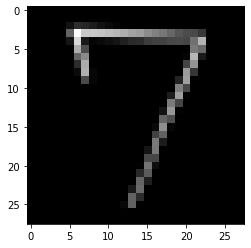

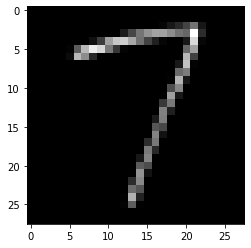

In [85]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_1 = Image.open('/content/hand-written-number-recognition/figs/7_1.png')
img_2 = Image.open('/content/hand-written-number-recognition/figs/7_2.png')
img_1, img_2 = img_1.convert('L'), img_2.convert('L')
img_1, img_2 = img_1.resize((28, 28)), img_2.resize((28, 28))
img_1, img_2 = np.array(img_1), np.array(img_2)

plt.figure()
plt.gray()
plt.imshow(img_1)
plt.figure()
plt.gray()
plt.imshow(img_2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_test = np.array(img_1)
y_test = np.array([7])

X_test = X_test.reshape(-1, 28, 28).astype('float32')
X_test /= 255

X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).long()

model.eval()
with torch.no_grad():
    inputs = X_test.view(1, 1, 28, 28).to(device)
    targets = y_test.to(device)
    # forward
    outputs = model(inputs)

print('True digit {:.0f} ({:.10f}), Prediction {:.0f} ({:.10f})'.format(
    targets.item(),
    torch.softmax(outputs, dim=1)[:, targets].item(),
    outputs.max(1)[1].item(),
    torch.softmax(outputs, dim=1).max(1)[0].item(),
))

X_test = np.array(img_2)
y_test = np.array([7])

X_test = X_test.reshape(-1, 28, 28).astype('float32')
X_test /= 255

X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).long()

model.eval()
with torch.no_grad():
    inputs = X_test.view(1, 1, 28, 28).to(device)
    targets = y_test.to(device)
    # forward
    outputs = model(inputs)

print('True digit {:.0f} ({:.10f}), Prediction {:.0f} ({:.10f})'.format(
    targets.item(),
    torch.softmax(outputs, dim=1)[:, targets].item(),
    outputs.max(1)[1].item(),
    torch.softmax(outputs, dim=1).max(1)[0].item(),
))